

## Food Image Classification
Given images of 101 diffrent foods, classify the foods presented in a given image.
We will use a TensorFlow/Keras pretrained MobileNetV2 CNN to make our predictions.
## Getting Started

In [1]:
#For working with the data
import numpy as np
import pandas as pd
from pathlib import Path
import os.path

#For visualisation
import matplotlib.pyplot as plt
import seaborn as sns

#For preprocessing
from sklearn.model_selection import train_test_split

#For building the model
import tensorflow as tf

#For analyzing the performance
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
image_dir = Path('../input/food41/images')

# Creating File DataFrame
for a dataframe to contain one column with all the path files and the other column with all the labels for each image associated with file path

In [3]:
filepaths = list(image_dir.glob(r'**/*.jpg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

#turns filepaths and labels into panda series and concatenates them into a data frame
filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

images = pd.concat([filepaths, labels], axis=1) #along axis=1 -> side by side

#there are too many images for this tutorial, therefore we are gone just use 100 imageges
#for each class
category_samples = []
for category in images['Label'].unique():
    category_slice = images.query("Label == @category")
    category_samples.append(category_slice.sample(100, random_state=1))
#axis=0 -> on top of each other; frac=1.0 -> sample 100% of the data without replacement
image_df = pd.concat(category_samples, axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)

In [4]:
image_df

,Filepath,Label
0,../input/food41/images/greek_salad/1330935.jpg,greek_salad
1,../input/food41/images/pancakes/3562559.jpg,pancakes
2,../input/food41/images/beef_carpaccio/484148.jpg,beef_carpaccio
3,../input/food41/images/french_fries/421038.jpg,french_fries
4,../input/food41/images/bread_pudding/689770.jpg,bread_pudding
...,...,...
10095,../input/food41/images/shrimp_and_grits/149216...,shrimp_and_grits
10096,../input/food41/images/sushi/2674024.jpg,sushi
10097,../input/food41/images/poutine/508222.jpg,poutine
10098,../input/food41/images/paella/265807.jpg,paella


In [5]:
images.query("Label == 'french_fries'")

,Filepath,Label
100000,../input/food41/images/french_fries/2246621.jpg,french_fries
100001,../input/food41/images/french_fries/1209297.jpg,french_fries
100002,../input/food41/images/french_fries/1437118.jpg,french_fries
100003,../input/food41/images/french_fries/619413.jpg,french_fries
100004,../input/food41/images/french_fries/1132539.jpg,french_fries
...,...,...
100995,../input/food41/images/french_fries/3663095.jpg,french_fries
100996,../input/food41/images/french_fries/2580653.jpg,french_fries
100997,../input/food41/images/french_fries/338259.jpg,french_fries
100998,../input/food41/images/french_fries/1327248.jpg,french_fries


In [6]:
image_df['Label'].value_counts()

greek_salad         100
huevos_rancheros    100
french_toast        100
tacos               100
clam_chowder        100
                   ... 
escargots           100
chicken_wings       100
crab_cakes          100
fried_rice          100
macarons            100
Name: Label, Length: 101, dtype: int64

# Train-Test Split

In [7]:
train_df, test_df = train_test_split(image_df, train_size=0.8, shuffle=True, random_state=1)

# Creating Generators
for loading the images of one batch at a time for not running out of memory

In [8]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [9]:
#speciffies which images will be used, then the generator takes images through the
#data frame, trains on them and recycles them
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical', #since it is a multi-class classification task
    batch_size=32,
    shuffle=True,
    seed=42, #to reproduce results
    subset='training' #only available when a validation split is used, specifies if 
                    #20% validation or 80% traing is taken
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical', #since it is a multi-class classification task
    batch_size=32,
    shuffle=True,
    seed=42, #to reproduce results
    subset='validation' #only available when a validation split is used, specifies if 
                    #20% validation or 80% traing is taken
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical', #since it is a multi-class classification task
    batch_size=32,
    shuffle=False
)

Found 6464 validated image filenames belonging to 101 classes.
Found 1616 validated image filenames belonging to 101 classes.
Found 2020 validated image filenames belonging to 101 classes.


# Modeling

In [10]:
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False, #defines if the final classifaction layer that the original model was trained on will be kept or not;
    #imagenet has 1000 classes, what we do not want here now, therefore we put our own classifaction layer at the top of the model
    weights='imagenet',
    pooling='avg' #ensure the output is one-dimensional
)

pretrained_model.trainable = False #ensures that we don't mess up the original net weight

2022-07-14 04:38:01.065147: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


9420800/9406464 [==============================] - 0s 0us/step


In [11]:
inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(101, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)

print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
______________________________________________________________________________________________

# Training

In [12]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy', #categorical_crossentropy, becuase we used Generators
    metrics=['accuracy'] #accuracy, because multi-class
)

history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=100,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            #when the validation loss stops improving for three consecutive epochs, we'll stop
            #training and restore the weights from the best epoch
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )
    ]
)

2022-07-14 04:38:02.992767: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100
202/202 [==============================] - 114s 548ms/step - loss: 3.6512 - accuracy: 0.1734 - val_loss: 2.8290 - val_accuracy: 0.3069
Epoch 2/100
202/202 [==============================] - 101s 497ms/step - loss: 2.2678 - accuracy: 0.4194 - val_loss: 2.5219 - val_accuracy: 0.3738
Epoch 3/100
202/202 [==============================] - 100s 495ms/step - loss: 1.7648 - accuracy: 0.5360 - val_loss: 2.4378 - val_accuracy: 0.3967
Epoch 4/100
202/202 [==============================] - 101s 498ms/step - loss: 1.4069 - accuracy: 0.6261 - val_loss: 2.4527 - val_accuracy: 0.4078
Epoch 5/100
202/202 [==============================] - 101s 499ms/step - loss: 1.1411 - accuracy: 0.6894 - val_loss: 2.4292 - val_accuracy: 0.4103
Epoch 6/100
202/202 [==============================] - 102s 502ms/step - loss: 0.8961 - accuracy: 0.7567 - val_loss: 2.5276 - val_accuracy: 0.4208
Epoch 7/100
202/202 [==============================] - 102s 502ms/step - loss: 0.6963 - accuracy: 0.8164 - val_loss: 2

# Results

In [13]:
results = model.evaluate(test_images, verbose=0) #verbose=0 ->to not get the loading bar
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

Test Accuracy: 41.83%


In [14]:
predictions = np.argmax(model.predict(test_images), axis=1)

cm = confusion_matrix(test_images.labels, predictions)
clr = classification_report(test_images.labels, predictions, target_names=test_images.class_indices, zero_division=0)

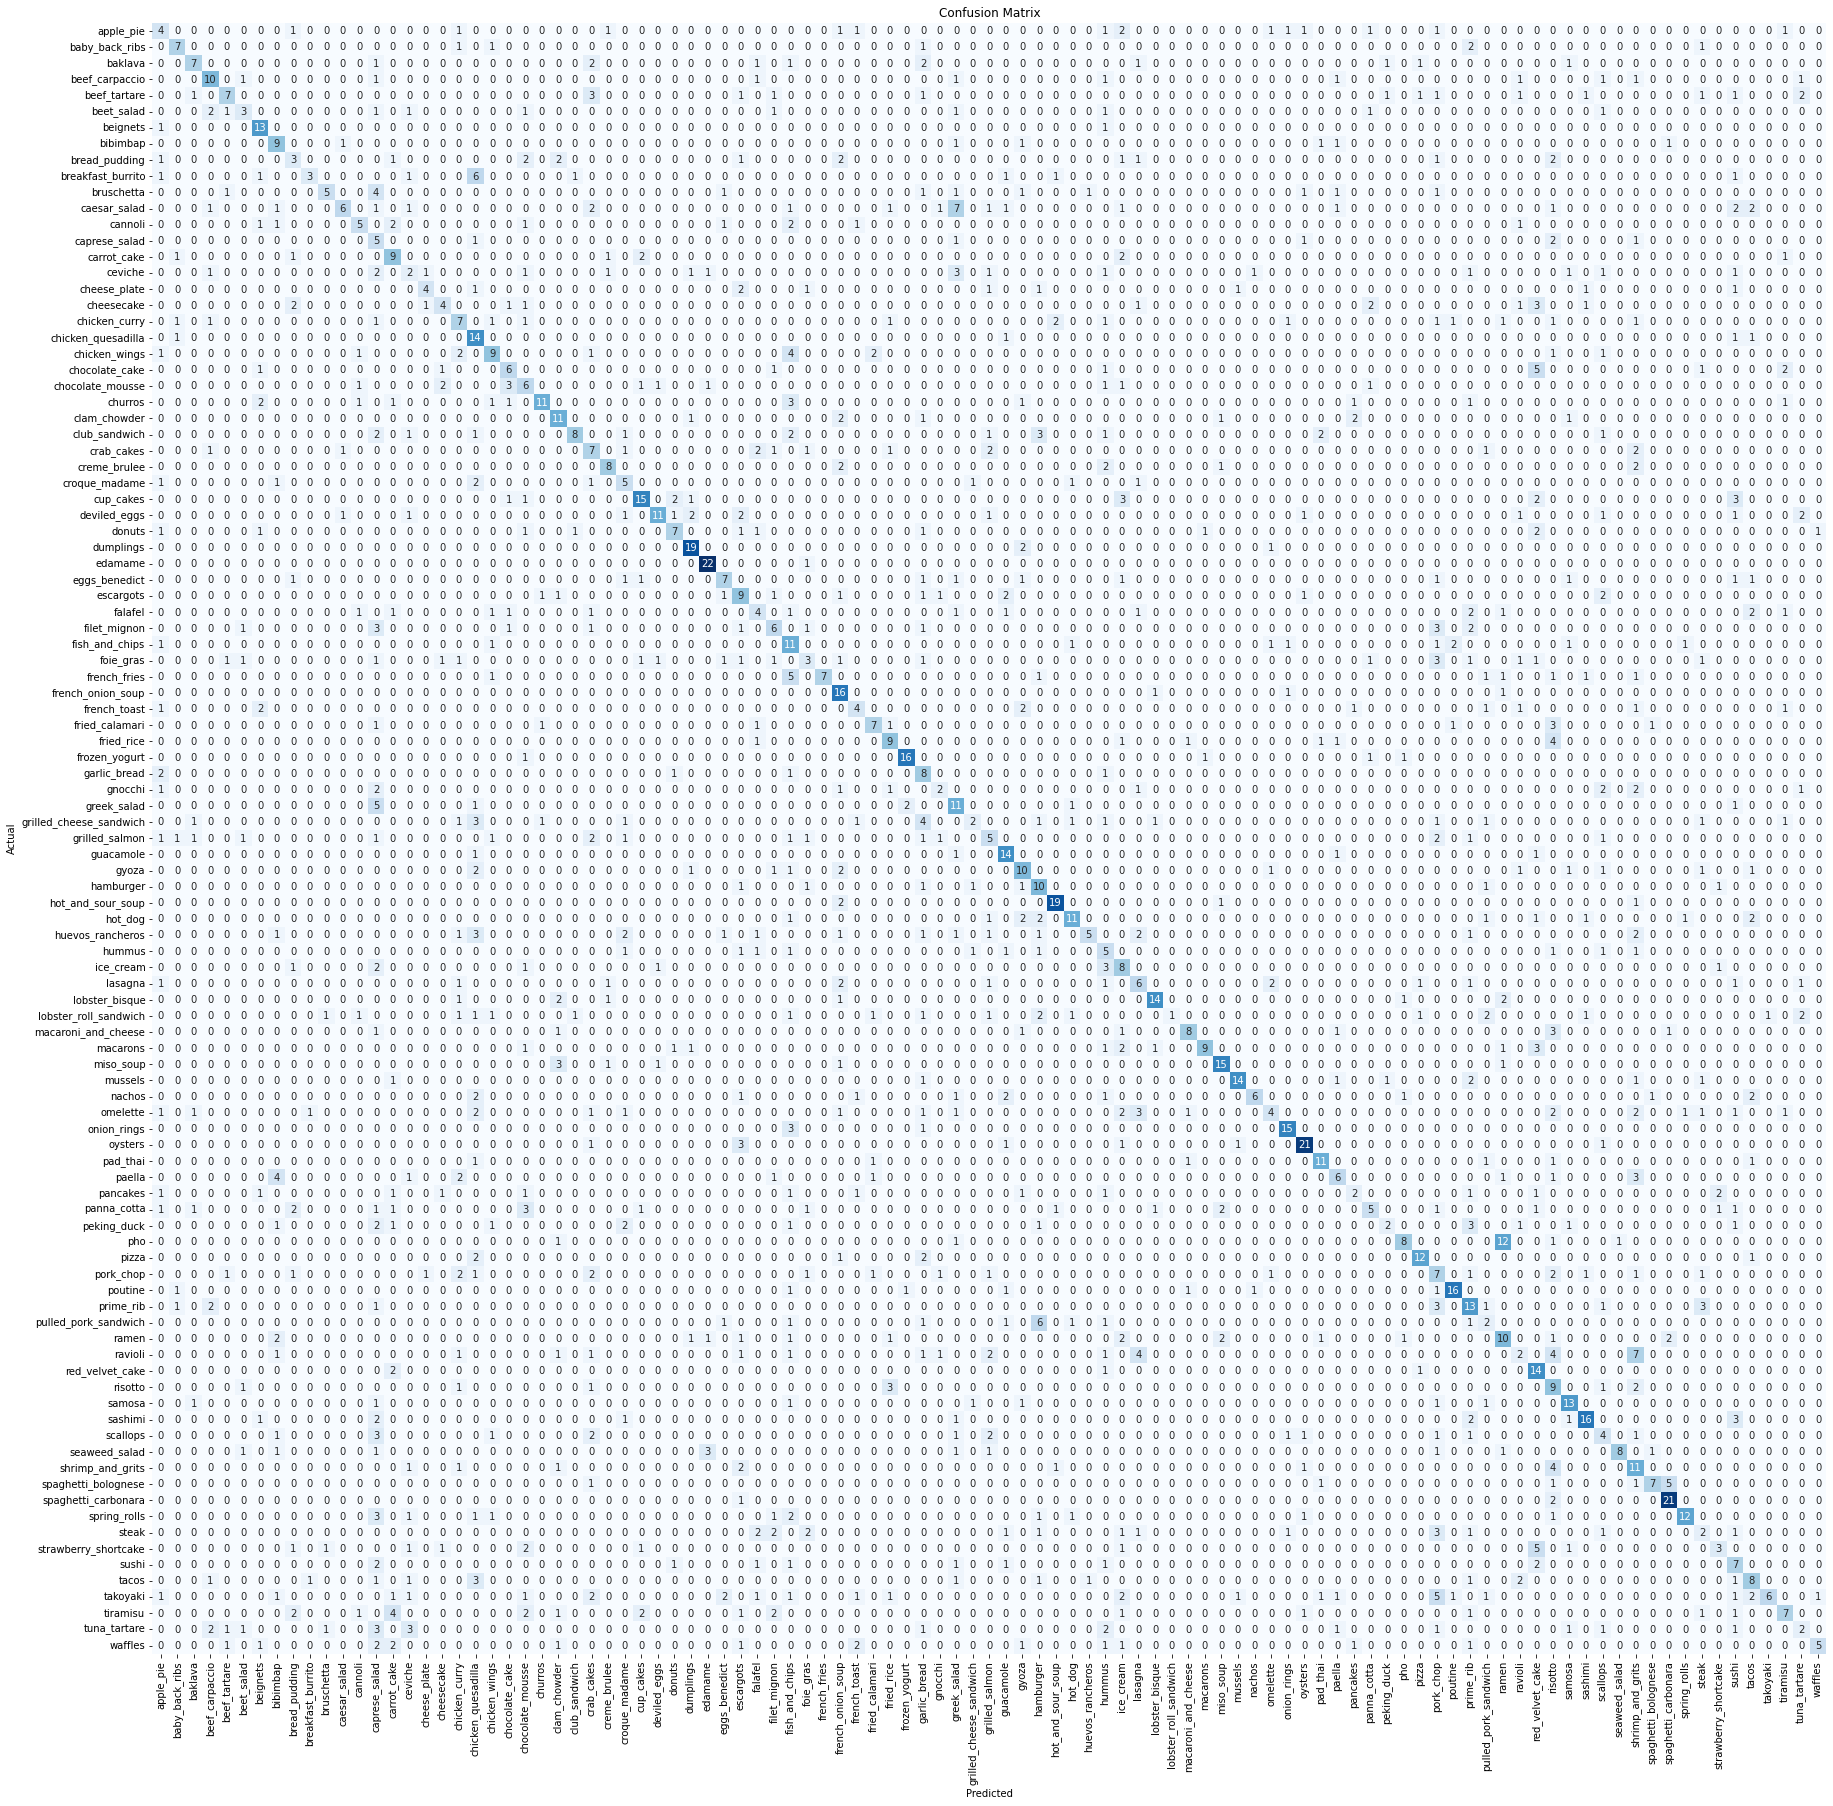

In [15]:
plt.figure(figsize=(30, 30))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xticks(ticks=np.arange(101) + 0.5, labels=test_images.class_indices, rotation=90)
plt.yticks(ticks=np.arange(101) + 0.5, labels=test_images.class_indices, rotation=0)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [16]:
print("Classification Report:\n----------------------\n", clr)

Classification Report:
----------------------
                          precision    recall  f1-score   support

              apple_pie       0.19      0.22      0.21        18
         baby_back_ribs       0.54      0.54      0.54        13
                baklava       0.54      0.39      0.45        18
         beef_carpaccio       0.48      0.50      0.49        20
           beef_tartare       0.54      0.30      0.39        23
             beet_salad       0.30      0.21      0.25        14
               beignets       0.54      0.87      0.67        15
               bibimbap       0.38      0.60      0.46        15
          bread_pudding       0.20      0.18      0.19        17
      breakfast_burrito       0.60      0.19      0.29        16
             bruschetta       0.62      0.28      0.38        18
           caesar_salad       0.67      0.19      0.30        31
                cannoli       0.45      0.33      0.38        15
          caprese_salad       0.09      0.